# Simulation: perfect controller

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cghiaus/dm4bem_book/HEAD?labpath=%2Ftutorials%2F02_2_4Toy.ipynb)

The simulation is done by [numerical integration](https://en.m.wikipedia.org/wiki/Numerical_integration) of the [state-space](https://en.m.wikipedia.org/wiki/State-space_representation) representation by using the description of the model as a thermal circuit, the input data set, and the weather data.

**Objectives:**
- Resample the inputs at time step.
- Create input vector in time.
- Integrate in time the state-space model.
- Plot the results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ctrl
import time

import dm4bem

The following assumptions can be done (see Figure 1):
- The indoor air temperature is not controlled (i.e., the building is in free running) or it is controlled by a P-controller having the gain $K_p = G_{11}.$
- The capacities of the air, $C_6$, and of the glass, $C_7$, can be neglected or not.
- The time integration is done by using Euler explicit or Euler implicit.
- The time step is calculated from the eigenvalues of the state matrix or it is imposed at a value designated as $\Delta t$.

![thermal_circuit](../figures/03_therm_circ.svg)
> Figure 1. Thermal circuit for the cubic building.

In [2]:
controller = True
Kp = 1e3    # W/°C, controller gain

neglect_air_capacity = False
neglect_glass_capacity = False

explicit_Euler = True

imposed_time_step = False
Δt = 3600    # s, imposed time step 

## State-space representation

The thermal circuit was described in the section on modelling. It is read from the file `./toy_model/TC.csv`. Thermal circuit is transformed in state-space representation.

In [3]:
# MODEL
# =====
# Thermal circuits
TC = dm4bem.file2TC('./toy_model/TC.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q11'] = Kp     # G11 = Kp, conductance of edge q11
                            # Kp -> ∞, almost perfect controller
if neglect_air_capacity:
    TC['C']['θ6'] = 0       # C6, capacity of vertex θ6 (air)
if neglect_glass_capacity:
    TC['C']['θ7'] = 0       # C7, capacity of vertex θ7 (glass) 

# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
dm4bem.print_TC(TC)

A:
      θ0   θ1   θ2   θ3   θ4   θ5   θ6   θ7
q0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q1  -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
q2   0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0
q3   0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0
q4   0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0
q5   0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0
q6   0.0  0.0  0.0  0.0 -1.0  0.0  1.0  0.0
q7   0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0
q8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
q9   0.0  0.0  0.0  0.0  0.0  1.0  0.0 -1.0
q10  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
q11  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 

G:
q0     1125.000000
q1      630.000000
q2      630.000000
q3       30.375000
q4       30.375000
q5       44.786824
q6      360.000000
q7       72.000000
q8      165.789474
q9      630.000000
q10       9.000000
q11    1000.000000
Name: G, dtype: float64 

C:
θ0           0.0
θ1    18216000.0
θ2           0.0
θ3      239580.0
θ4           0.0
θ5           0.0
θ6       32400.0
θ7     1089000.0
Name: C, dtype: float64 

b

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method),

$$\Delta t_{max} = \min (-2 / \lambda_i)$$ 

where $\lambda_i$ are the eigenvalues of the state matrix, gives the time step used in numerical integration.

In [4]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)

dt = 50 s


## Input data set

### One-hour time step
The input data set was described in the section on inputs. It is at the sampling time of 1 h (according to the weather file `.epw`, see notebook on [Inputs](02_2_3Toy.ipynb)).

In [5]:
# INPUT DATA SET
# ==============
input_data_set = pd.read_csv('./toy_model/input_data_set.csv',
                             index_col=0,
                             parse_dates=True)
input_data_set

,To,Ti_sp,Φo,Φi,Qa,Φa,Etot
2000-02-01 12:00:00+01:00,10.0,20,963.900000,48.195000,0.0,244.188000,71.400000
2000-02-01 13:00:00+01:00,11.0,20,945.000000,47.250000,0.0,239.400000,70.000000
2000-02-01 14:00:00+01:00,13.0,20,4071.565031,203.578252,0.0,1031.463141,301.597410
2000-02-01 15:00:00+01:00,11.0,20,548.100000,27.405000,0.0,138.852000,40.600000
2000-02-01 16:00:00+01:00,11.0,20,453.600000,22.680000,0.0,114.912000,33.600000
...,...,...,...,...,...,...,...
2000-02-07 14:00:00+01:00,6.0,20,2153.962611,107.698131,0.0,545.670528,159.552786
2000-02-07 15:00:00+01:00,6.0,20,1939.496251,96.974813,0.0,491.339050,143.666389
2000-02-07 16:00:00+01:00,6.0,20,734.151990,36.707599,0.0,185.985171,54.381629
2000-02-07 17:00:00+01:00,5.0,20,94.500000,4.725000,0.0,23.940000,7.000000


### Resample input data set

The weather data and the scheduled sources are at the time-step of 1 h. The data needs to be resampled at time step `dt` used for numerical integration.

In [6]:
input_data_set = input_data_set.resample(
    str(dt) + 'S').interpolate(method='linear')
input_data_set.head()

,To,Ti_sp,Φo,Φi,Qa,Φa,Etot
2000-02-01 12:00:00+01:00,10.000000,20.0,963.9000,48.195000,0.0,244.1880,71.400000
2000-02-01 12:00:50+01:00,10.013889,20.0,963.6375,48.181875,0.0,244.1215,71.380556
2000-02-01 12:01:40+01:00,10.027778,20.0,963.3750,48.168750,0.0,244.0550,71.361111
2000-02-01 12:02:30+01:00,10.041667,20.0,963.1125,48.155625,0.0,243.9885,71.341667
2000-02-01 12:03:20+01:00,10.055556,20.0,962.8500,48.142500,0.0,243.9220,71.322222


## Input vector in time

In the _input data set_ an input, e.g. $T_o$, appears only once. However, the _i nput vector_ may contain the same time series multiple time; for example, in the model presented in 
Figure 1, there are three inputs $T_o$ corresponding to branches $q_0$, $q_8$, and $q_{10}$). Therefore, we need to obtain the _input vector_ from the _input data set_.

The input in time is formed by the vectors of time series of temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]^T$:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

where the input data set is:

$T_o$: the time series vector of outdoor temperatures (from weather data), °C.

$T_{i,sp}$: time series vector of indoor setpoint temperatures, °C.

$\Phi_o$: time series vector of solar (i.e. short wave) radiation absorbed by the outdoor surface of the wall, W;

$\Phi_i$: time series vector of short wave (i.e. solar) radiation absorbed by the indoor surfaces of the wall, W;

$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), W.

$\Phi_a$: time series vector of short wave (i.e. solar) radiation absorbed by the window glass, W.

The *input vector* `u` is obtained from the *input data set*, $T_o, T_{i,sp}, \Phi_o, \Phi_i, \dot Q_a, \Phi_a$, by using the order of the sources given in the state-space model, `us`: `q0` = $T_o$, `q8` = $T_o$, `q10` = $T_o$, `q11` = $T_{i,sp}$, `θ0` = $\Phi_o$, `θ4` = $\Phi_i$, `θ6` = $\dot Q_a$, and `θ7` = $\Phi_a$.

In [7]:
# Input vector in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)
u.head()

,q0,q8,q10,q11,θ0,θ4,θ6,θ7
2000-02-01 12:00:00+01:00,10.000000,10.000000,10.000000,20.0,963.9000,48.195000,0.0,244.1880
2000-02-01 12:00:50+01:00,10.013889,10.013889,10.013889,20.0,963.6375,48.181875,0.0,244.1215
2000-02-01 12:01:40+01:00,10.027778,10.027778,10.027778,20.0,963.3750,48.168750,0.0,244.0550
2000-02-01 12:02:30+01:00,10.041667,10.041667,10.041667,20.0,963.1125,48.155625,0.0,243.9885
2000-02-01 12:03:20+01:00,10.055556,10.055556,10.055556,20.0,962.8500,48.142500,0.0,243.9220


## Initial conditions
The initial value of the state-vector can be zero or different from zero.

In [8]:
# Initial conditions
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0

## Time integration
The state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

is integrated in time by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

or [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$


where $k = 0, ... , n - 1$.

In [9]:
I = np.eye(As.shape[0])     # identity matrix

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])

## Outputs

From the time variation of state variable $\theta_s$ we obtain the time variation of the output $y$ (i.e., indoor temperature):

$$y = C_s \theta_s + D_s u$$

In [10]:
# outputs
y = (Cs @ θ.T + Ds @  u.T).T

and the variation in time of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

In [11]:
Kp = TC['G']['q11']     # controller gain
S = 9                   # m², surface area of the toy house
q_HVAC = Kp * (u['q11'] - y['θ6']) / S  # W/m²
y['θ6']

2000-02-01 12:00:00+01:00    20.000000
2000-02-01 12:00:50+01:00    19.923765
2000-02-01 12:01:40+01:00    19.971095
2000-02-01 12:02:30+01:00    19.927115
2000-02-01 12:03:20+01:00    19.950813
                               ...    
2000-02-07 17:56:40+01:00    18.918714
2000-02-07 17:57:30+01:00    18.917630
2000-02-07 17:58:20+01:00    18.916549
2000-02-07 17:59:10+01:00    18.915469
2000-02-07 18:00:00+01:00    18.914392
Freq: 50S, Name: θ6, Length: 10801, dtype: float64

## Plots

We select the data to plot:

- $T_o$, outdoor temperature, °C;
- $\theta_i$, indoor temperature, °C;
- $E_{tot}$, total solar irradiance, W/m²;
- $q_{HVAC}$, thermal load, i.e., the power that the HVAC system needs to deliver in order to maintain the indoor air temperature at its set-point, W.

In [12]:
data = pd.DataFrame({'To': input_data_set['To'],
                     'θi': y['θ6'],
                     'Etot': input_data_set['Etot'],
                     'q_HVAC': q_HVAC})

### Plots using Pandas

The plots mays be done by using `plot` method for DataFrame.

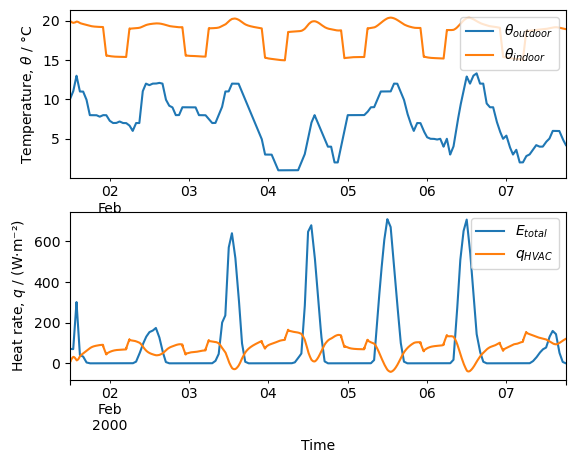

In [13]:
fig, axs = plt.subplots(2, 1)
data[['To', 'θi']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[1].set(xlabel='Time')
axs[1].legend(['$E_{total}$', '$q_{HVAC}$'],
              loc='upper right')
plt.show();

> Figure 2. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

### Plots using matplotlib

Alternatively, we may use `matplotlib`.

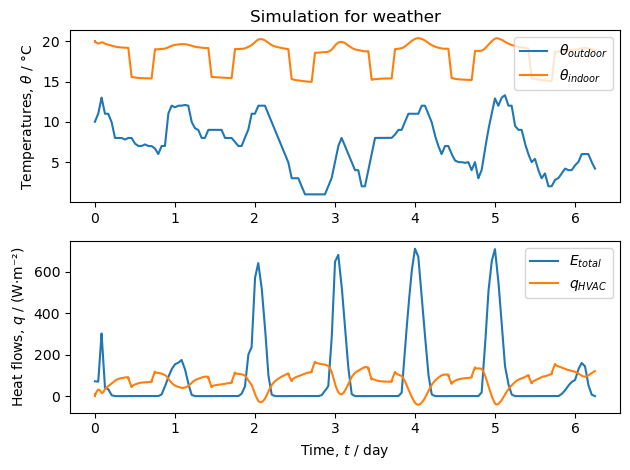

In [14]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y.values, label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Etot'], label='$E_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / (W·m⁻²)')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 3. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

## Discussion
### Numerical integration method

While fixed-step methods like Euler explicit or implicit integration can be simpler to implement and understand, they may not be the most efficient choice. Variable time step methods offer greater adaptability and efficiency, making them preferable for many simulation scenarios.

Let's compare the simulation time by using Euler explicit and variable time step used in [Python Control Systems Library](https://python-control.readthedocs.io/en/latest/generated/control.input_output_response.html).

The use of Euler numerical integration method is justified when the input vector varies during the numerical integration and changes are done in the _for loop_.

In [15]:
sys = ctrl.ss(As, Bs, Cs, Ds)

θ0 = 20.0 * np.ones(As.shape[0])  # °C, initial temperatures

The convention used by [Python Control Systems Library](https://python-control.readthedocs.io/en/latest/conventions.html) for time series is different from the convention used in Pandas and scipy.signal library: columns represent different points in time, rows are different components (e.g., inputs, outputs or states). Since _dm4bem_ uses Pandas, the vector of inputs in time must be transposed.

In [16]:
u_np = u.values.T       # inputs in time

In [17]:
start_time = time.time()

# Simulate the system response with Python Control Systems Library
t, yout = ctrl.input_output_response(sys, T=t, U=u_np, X0=θ0)

end_time = time.time()
duration_1 = end_time - start_time

In [18]:
start_time = time.time()

# Euler explicit
for k in range(u.shape[0] - 1):
    θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
y = (Cs @ θ.T + Ds @  u.T).T

end_time = time.time()
duration_2 = end_time - start_time

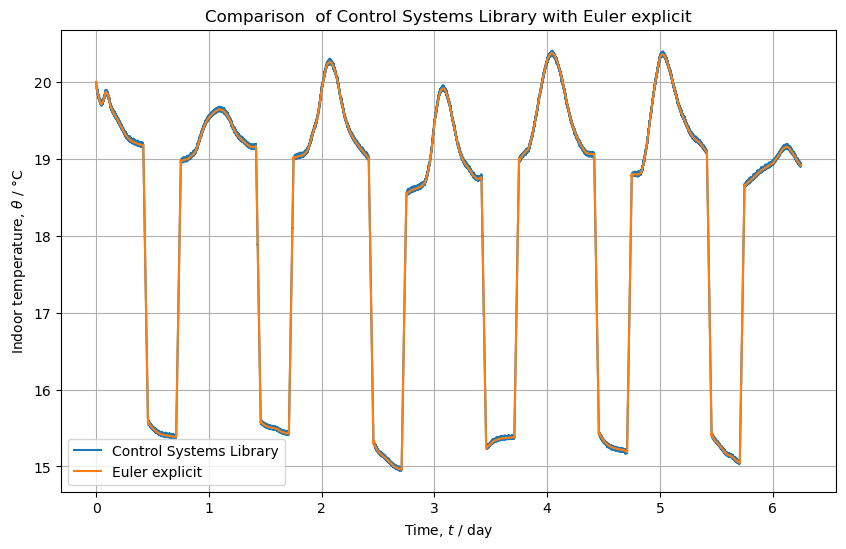

In [19]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.plot(t / 3600 / 24, yout[0], label='Control Systems Library')
axs.plot(t / 3600 / 24, y.values, label='Euler explicit')

axs.set(xlabel='Time, $t$ / day',
        ylabel='Indoor temperature, $θ$ / °C',
        title='Comparison  of Control Systems Library with Euler explicit')
axs.grid(True)
axs.legend()
plt.show()

> Figure 4. Time variation of indoor temperature obtained with Control Systems Library and for-loop Euler.

In [20]:
# Print the comparison of durations
print(f"Duration for Control Systems Library: {duration_1:.2f} seconds")
print(f"Duration for Euler explict:           {duration_2:.2f} seconds")

Duration for Control Systems Library: 1.40 seconds
Duration for Euler explict:           9.45 seconds


### Controller influence on time step

Simulate the system without controller (i.e., in free floating) and with controller.

Note that the time step for Euler explicit method depends on:

- Gain `TC['G']['q11'] = Kp` of the P-controller:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then, the controller is ineffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and of the glass $C_g =$ `C['Glass']` are considered, then the time step is small;
    - if the capacities of the air, `TC['C']['θ6']`, and of the glass, `TC['C']['θ6']`, are zero, then the time step is large (and the order of the state-space model is reduced).

The controller models an HVAC system able to heat (when $q_{HVAC} > 0$) and to cool (when $q_{HVAC} < 0$) when $K_p  \approx 10^3 \ \mathrm{W/K}$. Change $K_p  \approx 10^2 \ \mathrm{W/K}$ and $K_p  \approx 10^4 \ \mathrm{W/K}.$

## References

1. [C. Ghiaus (2013)](https://doi.org/10.1016/j.energy.2012.10.024). Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, , open access preprint: [HAL-03605823](https://hal.archives-ouvertes.fr/hal-03605823/document)

2. [C. Ghiaus (2021)](https://doi.org/10.1007/978-3-030-76477-7_5). Dynamic Models for Energy Control of Smart Homes, in *S. Ploix M. Amayri, N. Bouguila (eds.) Towards Energy Smart Homes*, Online ISBN: 978-3-030-76477-7, Print ISBN: 978-3-030-76476-0, Springer, pp. 163-198, open access preprint: [HAL 03578578](https://hal.archives-ouvertes.fr/hal-03578578/document)

3. [J.A. Duffie, W. A. Beckman, N. Blair (2020)](https://www.eng.uc.edu/~beaucag/Classes/SolarPowerForAfrica/Solar%20Engineering%20of%20Thermal%20Processes,%20Photovoltaics%20and%20Wind.pdf). Solar Engineering of Thermal Processes, 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

4. [Réglementation Thermique 2005. Méthode de calcul Th-CE.](https://pdfslide.fr/documents/rt2005-methode-de-calcul-th-ce.html). Annexe à l’arrêté du 19 juillet 2006

5. H. Recknagel, E. Sprenger, E.-R. Schramek (2013) Génie climatique, 5e edition, Dunod, Paris. ISBN 978-2-10-070451-4

6. [J.R. Howell et al. (2021)](http://www.thermalradiation.net/indexCat.html). Thermal Radiation Heat Transfer 7th edition, ISBN 978-0-367-34707-0, A Catalogue of Configuration Factors

7. [J. Widén, J. Munkhammar (2019)](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf). Solar Radiation Theory, Uppsala University